<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

<!-- from astropy.coordinates import get_sun -->

##Получение данных из excel

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np


###Создание датасета

In [208]:
df.columns

Index(['№ п/п', 'Время', 'Мощность, МВт',
       'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
       'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
       'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
       'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
       'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
       'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
       'Общая облачность',
       'Текущая погода, сообщаемая с метеорологической станции ',
       'Прошедшая погода между сроками наблюдения 1',
       'Прошедшая погода между сроками наблюдения 2',
       'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые обла

In [0]:
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
# import datetime

def make_dataset(df):
  numeric_columns=[
              'Мощность, МВт',
              'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
              'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
              'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
              'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
              'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
              'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
              ]
  series = df[numeric_columns].interpolate()# fillna(value=0)
              
              
  
  # добавление one-hot векторов значений для колонок 'Общая облачность' и "Высота облаков"

  clouds= df['Общая облачность'].astype('category')
  clouds_height=df['Высота основания самых низких облаков (м)'].astype('category')
  weather_2 = df['Прошедшая погода между сроками наблюдения 2'].fillna(method= 'ffill').astype('category')

  series=pd.concat([
                    series,
                    pd.get_dummies(clouds, prefix='Облака',dummy_na=True).fillna(value=0),
                    pd.get_dummies(clouds_height,prefix='Высота',dummy_na=True).fillna(value=0),
                    pd.get_dummies(weather_2,prefix='Погода')
                    ],axis=1)              
  # Черный яр : 48.060120° с.ш. 46.108620° в.д.
  # Географические координаты Черного Яра. Широта : 48°03′44″ с.ш. Долгота: 46°06′32″ в.д. Высота над уровнем моря: 1 м.
  # Астрахань 46.361433 48.060790

  location = EarthLocation(lon=46.361433, lat= 48.060790, height=-20)
  datetimes= Time(df.index.date.astype(np.datetime64)) + (df['Время'].dt.hour.to_numpy()+4) * u.hour
  frame = AltAz(obstime=datetimes, location=location)
  sun_altaz=get_sun(datetimes).transform_to(frame)
  
  series['Sun_alt']= sun_altaz.alt
  series['Sun_az'] = sun_altaz.az
  #series.drop(columns=['Время'])
  # # Добавление колонок "Время дня" и "Месяц года"
  # series.insert(0,'Месяц', series.index.month)
  # series.insert(1,'Время', series.index.hour)# series['Время'].map(lambda x: np.int(x.strftime('%H')))#.astype(np.string_)#.map(lambda x: x.strftime('%H'))

  # нормализация данных
  cols = numeric_columns
  data_mean= series.loc[:, cols].mean(axis=0)
  data_std = series.loc[:, cols].std(axis=0)
  series.loc[:, cols] = (series.loc[:, cols]-data_mean)/data_std
  return series
###################


In [0]:
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col="Дата")

# df['Location'] = 'Черный Яр'
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_6_Kharabali_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_7_Zelenga_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))

series=make_dataset(df)

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
### проба из https://www.tensorflow.org/tutorials/structured_data/time_series
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
# past_history = window_size
# future_target = 1
# STEP = 1
# ds= series.values
# target = series['Мощность, МВт'].values
# x_train_single, y_train_single = multivariate_data(ds, target, 0,
#                                                    split_datetime, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)

###Оформление оконного датасета

In [0]:
def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
  target_colnum=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1,target_colnum]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def make_splitdataset(df, split_pos):
  x_train = series[:split_pos]
  x_valid = series[split_pos:]

  ds_train = windowed_dataset(x_train, 'Мощность, МВт', window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
  ds_val = windowed_dataset(x_valid, 'Мощность, МВт', window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
  return ds_train, ds_val


##Сборка и тренировка модели

In [0]:
def make_model(train_shape):
  m = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(24, input_shape=(None, train_shape), return_sequences=True),
      #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
      tf.keras.layers.LSTM(12),
      tf.keras.layers.Dense(1)
    ])

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 20))

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-3)
  m.compile(loss="mse", optimizer=optimizer)
  return m
  
def train_model(model, train, validation, epoch_num=200):
  history = model.fit(train, validation_data=(validation), epochs=epoch_num)#,callbacks=[lr_schedule])
  return history

In [0]:
tf.keras.backend.clear_session()
window_size = int(24/4*3)
batch_size = 64
shuffle_buffer_size = 1000
split_datetime = 2500



In [0]:
train, validation = make_splitdataset(series, split_datetime)
Model = make_model(series.shape[1])

In [215]:
history = train_model(Model, train, validation, 300)

Epoch 1/300
39/39 [==============================] - 1s 25ms/step - loss: 0.6372 - val_loss: 0.2240
Epoch 2/300
39/39 [==============================] - 0s 11ms/step - loss: 0.3209 - val_loss: 0.1985
Epoch 3/300
39/39 [==============================] - 0s 10ms/step - loss: 0.2428 - val_loss: 0.1722
Epoch 4/300
39/39 [==============================] - 0s 9ms/step - loss: 0.2072 - val_loss: 0.1750
Epoch 5/300
39/39 [==============================] - 0s 10ms/step - loss: 0.1708 - val_loss: 0.1037
Epoch 6/300
39/39 [==============================] - 0s 8ms/step - loss: 0.1532 - val_loss: 0.1042
Epoch 7/300
39/39 [==============================] - 0s 9ms/step - loss: 0.1373 - val_loss: 0.0790
Epoch 8/300
39/39 [==============================] - 0s 9ms/step - loss: 0.1306 - val_loss: 0.1391
Epoch 9/300
39/39 [==============================] - 0s 9ms/step - loss: 0.1247 - val_loss: 0.1398
Epoch 10/300
39/39 [==============================] - 0s 8ms/step - loss: 0.1193 - val_loss: 0.1202
Epoch

In [0]:
import matplotlib.pyplot as plt
 
# lrs = 1e-5 * (10 ** (np.arange(epoch_num) / 20))
# plt.semilogx(lrs, history.history["val_loss"][:])
# # plt.axis([1e-5, 200, 0, 20])

###Анализ функции потерь

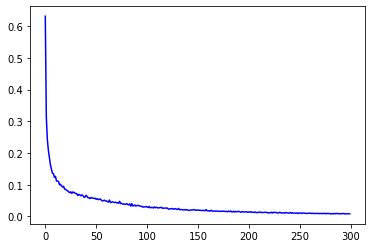

In [202]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[0.0538829043507576, 0.05609988048672676, 0.05302437022328377, 0.053885843604803085, 0.05510684847831726, 0.05151498690247536, 0.048919834196567535, 0.04949319735169411, 0.05134197324514389, 0.049099165946245193, 0.04875560849905014, 0.046709101647138596, 0.04534587264060974, 0.05161408334970474, 0.04370785877108574, 0.044906701892614365, 0.0460544154047966, 0.0450814887881279, 0.04379083588719368, 0.0445503331720829, 0.04332055523991585, 0.04303724691271782, 0.04149259626865387, 0.047433748841285706, 0.04056675359606743, 0.041280824691057205, 0.03897581994533539, 0.039376966655254364, 0.03792378306388855, 0.038461584597826004, 0.040249280631542206, 0.037623196840286255, 0.036235261708498, 0.03971592336893082, 0.032551635056734085, 0.0402655303478241, 0.03294793888926506, 0.034176573157310486, 0.035801343619823456, 0.03254888579249382, 0.03447931259870529, 0.034768249839544296, 0.033987775444984436, 0.03284073993563652, 0.031443968415260315, 0.032018035650253296, 0.029236292466521263, 

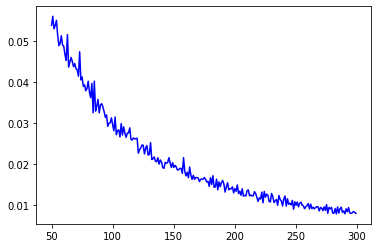

In [203]:
# Plot all but the first 10
loss = history.history['loss']
startpos= 50
epochs = range(50, len(loss))
plot_loss = loss[50:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

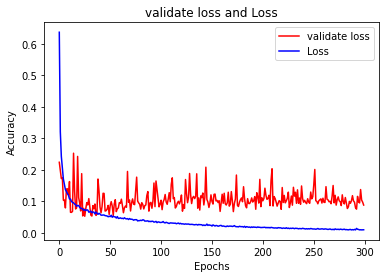

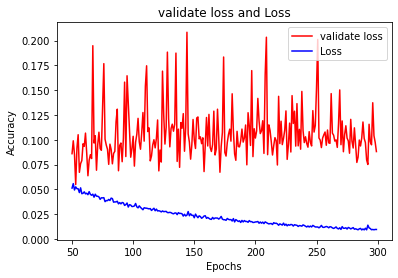

<Figure size 432x288 with 0 Axes>

In [216]:
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validate loss and Loss
#------------------------------------------------
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = val_loss[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed validate loss and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

### График сравнения предсказанной мощности с реальной, взятой из таблицы

In [0]:
forecast=[]
for t in range(split_datetime-window_size,len(series) - window_size):
  pred=np.expand_dims(series[t:t+window_size],0)
  forecast.append(Model.predict(pred).flatten())

results = forecast
results = np.squeeze(forecast)#[:, 0, 0]




In [0]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format, )
    plt.xlabel("Time")
    plt.ylabel("Value")
    # plt.legend(legend)
    plt.grid(True)

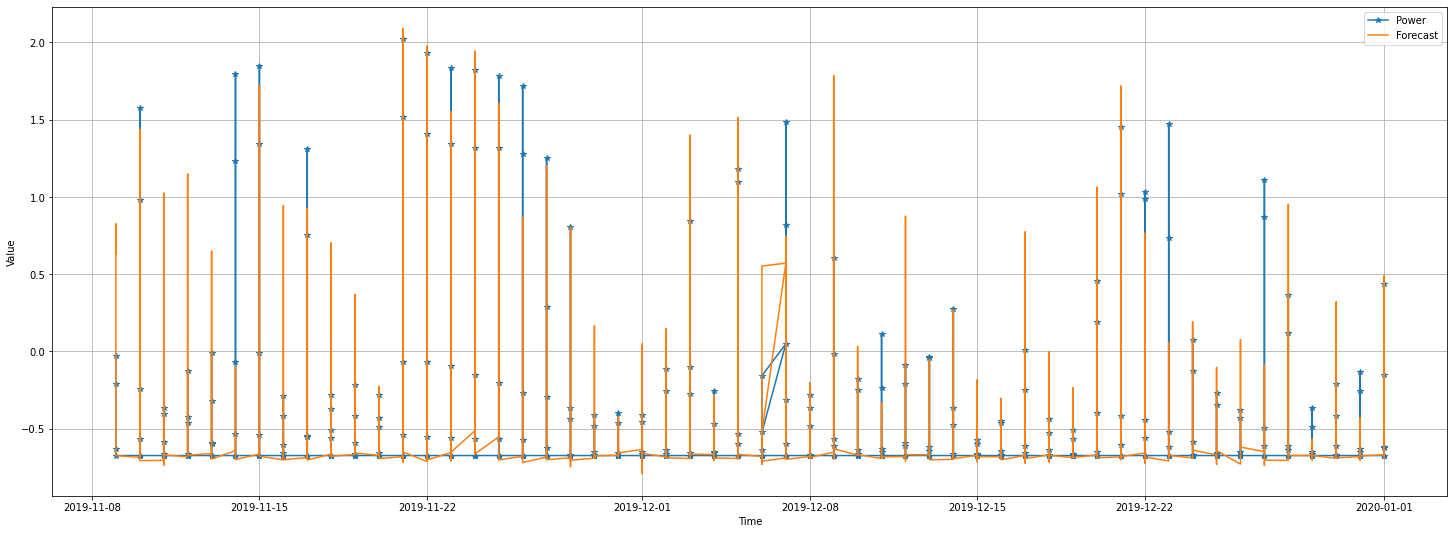

In [226]:
#import matplotlib.pyplot as plt

time_train = series[split_datetime:].index#.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(25, 9))
# plt.ylim(top=2)
plot_series(time_train, series[split_datetime:]['Мощность, МВт'], format='-*')#,start=300)#,end=200)
plot_series(time_train, results)#,start=300)#,end=200)
plt.legend(['Power', 'Forecast'])